In [1]:
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GRU, LSTM, Dense, Flatten, TimeDistributed
import matplotlib.pyplot as plt

In [42]:
number_of_frames = 30
width = 30
height = 20

In [47]:
# generate the next frame in the sequence 
def make_frame(last_row, column): 
    frame = np.zeros((height, width))
    
    # define the row scope of the next row 
    lower = max(0, last_row-2) 
    upper = min(height-1, last_row+2) 
    
    # choose the next row index 
    row = random.randint(lower, upper) 
    cv2.circle(frame, (column, row), 2, 255, -1) 
    return frame, row

In [48]:
# generate a sequence of frames of a dot moving across an image 
def make_data(): 
    frames = []
    row = random.randint(0, height-1) 
    label = 1 if random.random() < 0.5 else 0  # 0:left and 1:right
    col = 0 if label==1 else width-1 

    # create all frames 
    for i in range(number_of_frames):
        col = i if label==1 else width-1-i 
        frame, row = make_frame(row, col) 
        frames.append(frame) 
    return frames, label

In [49]:
# generate multiple sequences of frames and reshape for network input 
def generate_dataset(dataset_size):
    X, Y = [], []
    for _ in range(dataset_size): 
        frames, label = make_data() 
        X.append(frames) 
        Y.append(label) 
    
    X = np.array(X) 
    Y = np.array(Y)
    X = X[..., np.newaxis]
    Y = Y[..., np.newaxis]
    return X, Y

<-- Left


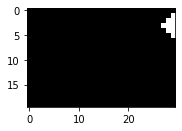

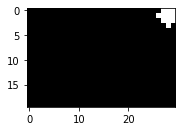

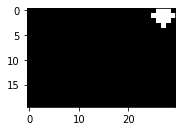

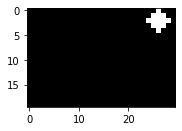

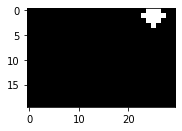

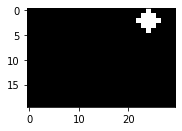

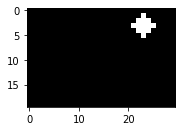

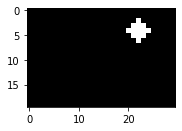

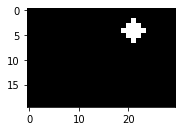

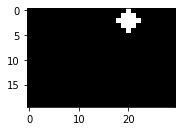

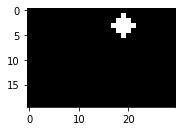

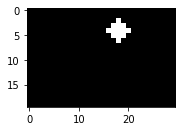

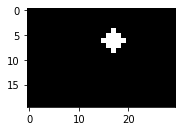

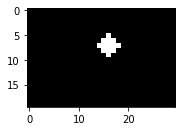

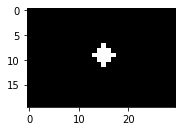

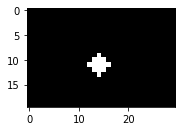

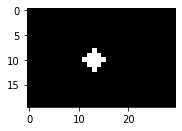

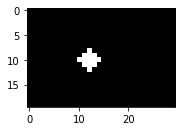

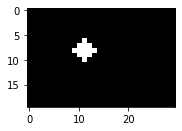

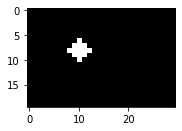

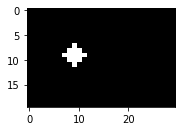

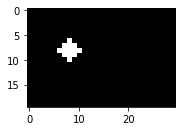

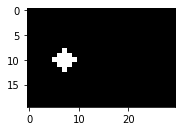

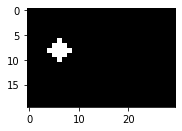

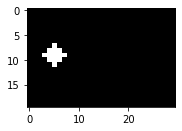

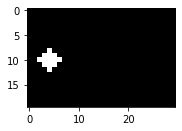

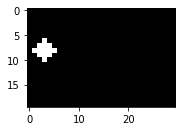

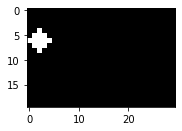

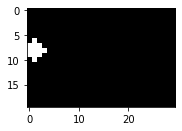

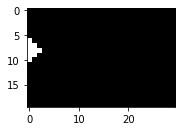

In [50]:
X, Y = generate_dataset(1)

print("Right -->") if Y[0] else print("<-- Left")
for frame in X[0]:
    plt.subplot(2, 2, 1)
    plt.imshow(frame[:,:,0], cmap="gray")
    plt.show()

In [51]:
X_train, Y_train = generate_dataset(1000) 
print(X_train.shape)
print(Y_train.shape)

(1000, 30, 20, 30, 1)
(1000, 1)


In [58]:
model = tf.keras.models.Sequential([
    TimeDistributed(Conv2D(2, (3, 3), activation='relu'), input_shape=(None, height, width, 1)),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    TimeDistributed(Flatten()),
    GRU(50),
    Dense(2, activation='softmax')
])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, None, 18, 28, 2)   20        
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 9, 14, 2)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 252)         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 50)                45600     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 45,722
Trainable params: 45,722
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy']) 

In [60]:
model.fit(X_train, Y_train, batch_size=32, epochs=2)

Epoch 1/2
32/32 [==============================] - 2s 29ms/step - loss: 0.2332 - accuracy: 0.9000
Epoch 2/2
32/32 [==============================] - 1s 28ms/step - loss: 0.0060 - accuracy: 1.0000


In [61]:
# evaluate model 
X_test, Y_test = generate_dataset(100) 
model.evaluate(X_test, Y_test) 

4/4 [==============================] - 0s 9ms/step - loss: 0.0053 - accuracy: 1.0000


[0.005276803392916918, 1.0]

In [64]:
# prediction on new data 
x, y = generate_dataset(1) 
output = model.predict(x)
y_pred = np.argmax(output)
expected = "Right" if y[0]==1 else "Left" 
predicted = "Right" if y_pred==1 else "Left" 
print(f'Expected: {expected}, Predicted: {predicted}')

Expected: Right, Predicted: Right
